# Experiments LSTM net

Here we tried to replicate the network that was used in [this](https://www.nature.com/articles/s41598-018-33321-1#Sec2) paper. But instead of using GRU we used LSTM. 

In [2]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_loader.data_loader import PhageLoader

%matplotlib inline

## LSTM

In [33]:
class BasicLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_dim, sequence_length, batch_size, labset_dim=2, number_of_layers=1, bidirectional=True, device=torch.device("cpu")):
        super(BasicLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.num_layers = number_of_layers
        self.device = device
        
        hidden_dim_dense = hidden_dim
        if bidirectional:
            hidden_dim_dense = hidden_dim * 2
        
        self.kmer2embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_dim ,bidirectional=bidirectional,num_layers=number_of_layers)
        self.dense = nn.Linear(hidden_dim_dense, labset_dim)        


    def forward(self, sequence):
        # Input (shape: )
        embedded_kmers = self.kmer2embedding(sequence)

        # embeddings -> LSTM hiddens (seq_len, batch, num_directions * hidden_size)
        out_lstm, _ = self.lstm(embedded_kmers.view(self.sequence_length, self.batch_size, -1)) 

        # LSTM hiddens -> dense layer 
        out_dense = self.dense(out_lstm.view(-1, self.hidden_dim*2))

        # dense layer -> probabilities
        out_log = F.log_softmax(out_dense, dim = 1)
        return out_log
    
    # Not being used for now
    def initHidden(self, batch_size, hidden_size):
        if self.bidirectional:
            return torch.zeros(self.num_layers*2, batch_size, hidden_size, device=this.device)
        else:
            return torch.zeros(self.num_layers, batch_size, hidden_size, device=this.device)
        
    # Not being used for now
    def create_emb_layer(self, weights_matrix, non_trainable=False):
        num_embeddings, embedding_dim = weights_matrix.size()
        emb_layer = nn.Embedding(num_embeddings, embedding_dim)
        emb_layer.load_state_dict({'weight': weights_matrix})
        if non_trainable:
            emb_layer.weight.requires_grad = False
            
        return emb_layer, num_embeddings, embedding_dim

In [7]:
# Setting up for working with GPU, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [36]:
# parameters for grid search
window_sizes = [3] # [1, 3, 5, 7]
strides = [1] # [1, 2]
batch_sizes = [30] # [30, 60, 120] 
embedding_layer_sizes = [50] # [50, 100]
hidden_layer_sizes = [30] # [30, 50, 80]
epochs_values = [1] # [10, 50, 100]
optimizers = ['SGD']#['SGD', 'ADAM']
learning_rates = [0.1] # [0.1, 0.01, 0.001] 

# other important parameters
#VOCAB_SIZE = len(kmers_dict)
LABSET_DIM = 2
BIDIRECTIONAL = True
sequence_length = 100
genomes_to_use = 1 # len(loaders) for all genomes

In [9]:
# get dataset
loader = PhageLoader("data/")

In [10]:
from itertools import product

hyperparams_configs = list(product(window_sizes, \
                                   strides, batch_sizes, \
                                   embedding_layer_sizes, \
                                   hidden_layer_sizes, \
                                   epochs_values, \
                                   optimizers, \
                                   learning_rates))
hyperparams_configs

[(3, 1, 30, 50, 30, 1, 'SGD', 0.1)]

In [11]:
# Here just to speed up prototyping but it should be inside the loop
experiment_loader = loader.get_data_loader(n='all',read_length=sequence_length, batch_size=30, k=3, stride=1, embedding="dict", embed_size=None, drop_last=False)
# n -> how many files to bring
# read_length -> length of the sequence to read (in terms of number of k-mers)
# batch_size -> number of rows to recieve of length "read_length"
# k -> k-mer k
# stride -> stride for the kmer read
# embedding: "dict" to return a dictionary with the combinations of letters

In [38]:
# TRAIN
# Set up the experiment 

for (window_size, stride, batch_size, embedding_layer_size, hidden_layer_size, epochs, optimizer, learning_rate) in hyperparams_configs:
    
    print('Running experiment with (window_size = %s, stride = %s, batch_size = %s, embedding_layer_size = %s, hidden_layer_size = %s, epochs = %s, optimizer = %s, learning_rate = %s)' % (window_size, stride, batch_size, embedding_layer_size, hidden_layer_size, epochs, optimizer, learning_rate))
    
    VOCAB_SIZE = 4**window_size

    # Transform dataset appropiately (I take this line out for now because it takes a lot of time)
    # experiment_loader = loader.get_data_loader(n='all',read_length=100, batch_size=batch_size, k=window_size, stride=stride, embedding="dict", embed_size=None, drop_last=False)
    train_set_size = round(len(experiment_loader) * 0.1) # Use 10% for now
    validation_set_size = round(len(experiment_loader) * 0.1) # Use 10% for now
    test_set_size =  len(experiment_loader) - (train_set_size + validation_set_size)
    
    basicLSTM = BasicLSTM(vocab_size = VOCAB_SIZE, \
              embedding_size = embedding_layer_size, \
              hidden_dim = hidden_layer_size,\
            sequence_length = 100, \
            batch_size = batch_size, \
              labset_dim= LABSET_DIM,\
              number_of_layers = 1, \
              bidirectional=BIDIRECTIONAL, \
              device=device)
    
    basicLSTM.to(device) # will move to cuda if available
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(basicLSTM.parameters(), lr=learning_rate)
    if optimizer == 'ADAM':
        pass # use ADAM

    losses = []
    running_loss = 0

    for epoch in range(epochs):

            # Iterate over all the training set
            for b, (x, y) in enumerate(experiment_loader):

                if b == train_set_size: 
                    break

                basicLSTM.zero_grad()                    
                x = x.type(torch.LongTensor)
                y = y.type(torch.LongTensor)
                x, y = x.to(device), y.to(device)
                if y.size()[0] != batch_size:
                    break

                out = basicLSTM(x)  
                y = y.view(batch_size*sequence_length)
                out = out.view(batch_size*sequence_length,2)
                loss = loss_function(out, y)
                losses.append(loss.item())

                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                if b % 10 == 9:
                #if i % 2000 == 1999:    # print every 2000 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, b + 1, running_loss / 2000))
                    running_loss = 0.0
    
    # TODO: validate on validation set 

Running experiment with (window_size = 3, stride = 1, batch_size = 30, embedding_layer_size = 50, hidden_layer_size = 30, epochs = 1, optimizer = SGD, learning_rate = 0.1)
[1,    10] loss: 0.003
[1,    20] loss: 0.002
[1,    30] loss: 0.001
[1,    40] loss: 0.001
[1,    50] loss: 0.001
[1,    60] loss: 0.001
[1,    70] loss: 0.001
[1,    80] loss: 0.001
[1,    90] loss: 0.001
[1,   100] loss: 0.001
[1,   110] loss: 0.001
[1,   120] loss: 0.001
[1,   130] loss: 0.002
[1,   140] loss: 0.001
[1,   150] loss: 0.001
[1,   160] loss: 0.002
[1,   170] loss: 0.001
[1,   180] loss: 0.001
[1,   190] loss: 0.001
[1,   200] loss: 0.001
[1,   210] loss: 0.001
[1,   220] loss: 0.002
[1,   230] loss: 0.002
[1,   240] loss: 0.001
[1,   250] loss: 0.001
[1,   260] loss: 0.001
[1,   270] loss: 0.001
[1,   280] loss: 0.002
[1,   290] loss: 0.003


* It takes 3:30 minutes to train the network with 558 parameters and 11173 sequences of 10 kmers each. (1 genome)
* It takes 26:30 minutes to train the network with 29314 parameters and Y sequences of 100 kmers each. (10 genomes)
* It takes more or less 40 minutes to train the network on google cloud with CPU with 29314 parameters and Y sequences of 100 kmers each. (10 genomes)

In [16]:
# Number of trainable parameters of pytorch model
#pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params = sum(p.numel() for p in basicLSTM.parameters() if p.requires_grad)
pytorch_total_params

29314

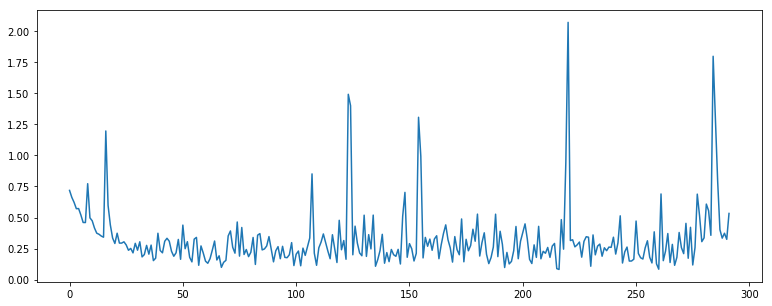

In [39]:
#losses
plt.figure(figsize=(13,5))
sns.lineplot(x=range(len(losses)),y=losses)

In [17]:
# Test
total = 0
correct = 0
with torch.no_grad():
    for i, (raw_kmer, raw_labels) in enumerate(test):
        kmer = prepareSequence(raw_kmer, kmers_dict)
        labels = torch.tensor(raw_labels)
        out = basicLSTM(labels)
        _, predicted = torch.max(out, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    

In [18]:
# This is a bad result given that roughly 75% of the test set are 0's ... it means it gets all the ones wrong
correct/total

0.556365202411714

In [19]:
# Number of '1's in the test set
sum([item for sublist in (b for a,b in test) for item in sublist])/len([item for sublist in (b for a,b in test) for item in sublist])

0.44363479758828595

In [146]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
classes = {0: 'inter-genic', 1: 'genic'}

with torch.no_grad():
    for i, (raw_kmer, raw_labels) in enumerate(test):
        kmer = prepareSequence(raw_kmer, kmers_dict)
        labels = torch.tensor(raw_labels)
        out = basicLSTM(labels)
        _, predicted = torch.max(out, 1)
        c = (predicted == labels).squeeze()
        for i in range(1):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of inter-genic : 100 %
Accuracy of genic :  0 %


In [145]:
?torch.Tensor.squeeze

Docstring:
squeeze(dim=None) -> Tensor

See :func:`torch.squeeze`
Type:      method_descriptor
